In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad
from scipy.optimize import minimize

import arviz as az

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="dark")

from src.likelihood import LogLikelihood
from src.velocity import velocity
from src.sampler_jax import hmc, hamiltonian_side_move, hamiltonian_walk_move
from src.visualize.corner import corner

# Create Fake Radial Velocity Data

/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_60759/227973648.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "+k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')


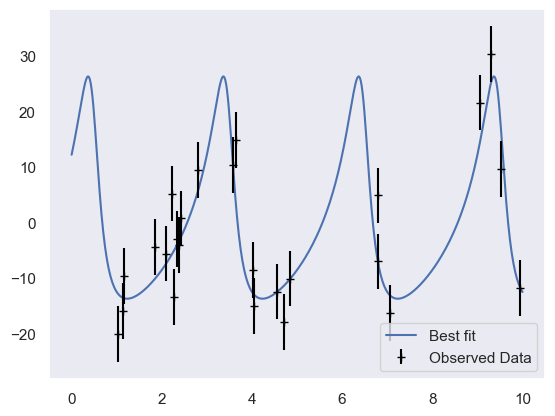

In [4]:
tf = 10
t = jnp.linspace(0, tf, 500)  # 500 time points over 10 days

# Orbital parameters
period = 3.0          # Orbital period in days
eccentricity = 0.48    # Moderate eccentricity (0 <= ecc < 1)
omega = 7.0          # Argument of periastron in radians 
phi0 = 1.0            # Phase offset (in radians)
K = 20.0              # Semi-amplitude of velocity in m/s
v0 = 0.0              # Systemic velocity offset in m/s

labels = ['period', 'eccentricity', 'omega', 'phi0', 'K', 'v0']
initial_params = jnp.array([period, eccentricity, omega, phi0, K, v0])

# True Data
rv_true = velocity(t, period, eccentricity, omega, phi0, K, v0)

# Observed Data
n_observed = 25
time_obs = np.sort(np.random.uniform(0, tf, n_observed))
rv_err = 5
rv_obs = velocity(time_obs, period, eccentricity, omega, phi0, K, v0) + rv_err * np.random.normal(size=len(time_obs))


plt.plot(t, rv_true, label="Best fit")
plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')
plt.legend(loc='lower right')
plt.show()


# Maximum Likelihood Inference, using `jax.scipy.optimize.minimize`

In [5]:
loglikelihood = LogLikelihood(times=time_obs, 
                              observed_data=rv_obs, 
                              uncertainity=rv_err, 
                              jitter=0.0)

In [6]:
neglikelihood = lambda params: -1 * loglikelihood(params)

neg_likelihood_grad = jax.jit(grad(neglikelihood))

# Starting point
# period, eccentricity, omega, phi0, K, v0
initial_params = jnp.array([period, eccentricity, omega, phi0, K, v0])

# Wrapper for SciPy which works with jax.np
def scipy_obj(params_np):
    params = jnp.array(params_np)
    val = float(neglikelihood(params))
    grad_val = jnp.array(neg_likelihood_grad(params))
    return val, grad_val

# Optimize
# period, eccentricity, omega, phi0, K, v0
speed_of_light = 1000
res = minimize(scipy_obj, 
               x0=initial_params, 
               jac=True, 
               bounds=(
                   (0.0, None),                        # Period
                   (0.0, 1,0),                         # Eccentricity
                   (0.0, 2*jnp.pi),                    # $\omega$
                   (-1*jnp.pi, 1*jnp.pi),              # $\phi_0$
                   (0.0, None),                        # K
                   (-speed_of_light, speed_of_light)   # $v_0$
                   )
                )

# Best-fit parameters
best_params = res.x
print("Optimized parameters:", best_params)
print(f"Best loglikelihood: {loglikelihood(best_params)}")
print(res)

Optimized parameters: [ 3.02636849  0.28245846  6.28318531  0.17006901 20.62988365  6.19684156]
Best loglikelihood: -21.663478610870797
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 21.663478610870797
        x: [ 3.026e+00  2.825e-01  6.283e+00  1.701e-01  2.063e+01
             6.197e+00]
      nit: 37
      jac: [-8.467e-05  1.297e-04 -1.349e+01  9.161e-07  2.341e-05
            -5.091e-06]
     nfev: 43
     njev: 43
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_60759/2181155865.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "+k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')


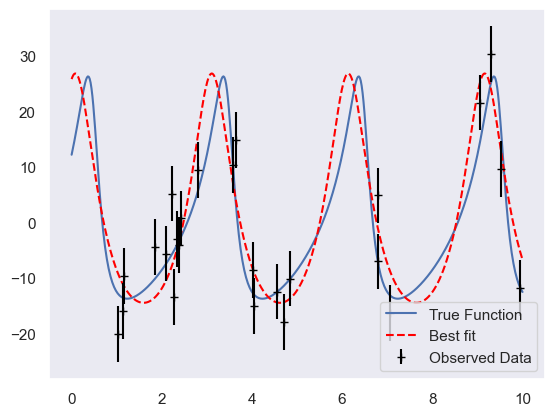

In [7]:
period_best, eccentricity_best, omega_best, phi0_best, K_best, v0_best  = best_params

# Visualization
plt.plot(t, rv_true, label="True Function")
plt.plot(t, velocity(t=t, period=period_best, eccentricity=eccentricity_best, omega=omega_best, phi0=phi0_best, K=K_best, v0=v0_best), label="Best fit", color='red', linestyle='--')
plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')
plt.legend(loc='lower right')
plt.legend()
plt.show()


# Inspecting Gradients of Log Likelihood

In [ ]:
target_indx = 0
values = jnp.linspace(0, 1, 100)

static_params = [period_best, eccentricity_best, omega_best, phi0_best, K_best, v0_best]
static_params[target_indx] = values

def foo(target_indx):
    result = []
    for i in range(len(initial_params)):
        if i == target_indx:
            result.append(0)
        else:
            result.append(None)
    return tuple(result)



(None, 0, None, None, None, None)

In [34]:
loglikelihood(initial_params)

Array(-19.11428446, dtype=float64)

In [38]:


for arg_idx in range(len(initial_params)):
    velocity_setTime = lambda period, eccentricity, omega, phi0, K, v0: velocity(t, period, eccentricity, omega, phi0, K, v0)
    partial_velocity = jax.vmap(jax.grad(velocity_setTime, argnums=arg_idx), in_axes=foo(arg_idx))
    partial_velocity_values = partial_velocity(*static_params)
    print(partial_velocity_values.shape)
    plt.plot(t, partial_velocity_values, label=f"Partial Velocity w.r.t. {labels[arg_idx]}")

plt.legend()
plt.show()


TypeError: Gradient only defined for scalar-output functions. Output had shape: (500,).